# Simulating and plotting neurons

This notebook is a quick introduction on how to **simulate** and **analyse** neuron activity - that is neuron activity over time. Specifically you will learn how to simulate single neurons and plot their voltage traces, current traces, and spikes. 

:::{note}
You can execute the notebooks on this website by hitting <i class="fas fa-rocket"></i> above and pressing <i class="fas fa-play"></i> Live Code.
:::

First of all we need to install and import some prerequisites:

In [ ]:
!pip install -q matplotlib numpy scipy tqdm norse

In [1]:
import torch          # PyTorch

# Import a the leaky integrate-and-fire feedforward model
from norse.torch.module.lif import LIF

## Creating leaky integrate-and-fire (LIF) neurons

To start simulating we need to create a population of LIF neurons of an arbitrary size. Each neuron in the population is set to a default state. We will not be covering this particular neuron model in this tutorial, but can find more information [here](https://norse.github.io/norse/auto_api/norse.torch.module.lif.html) and in our other tutorials.

Really, the only thing you need to remember is that that the neurons will **receive currents as inputs**, and **produce spikes** (0 and 1) as outputs.

In [2]:
# Creates a LIF population of arbitrary size
# Note that we record all the states for future use (not recommended in production)
lif = LIF(record_states=True)
lif

LIF(p=LIFParameters(tau_syn_inv=tensor(200.), tau_mem_inv=tensor(100.), v_leak=tensor(0.), v_th=tensor(1.), v_reset=tensor(0.), method='super', alpha=tensor(100.)), dt=0.001)

# 1. Simulating a single neuron

To actually use the neuron, we need to **simulate it in time**.
Why in time? Well, neurons works by **integrating current over time**.
In Norse, time is discretized into **steps**, where each step *advances* the neuron simulation a bit into the future.
If this confuses you, take a look at the earlier [Tutorial on spiking neurons in PyTorch](https://norse.github.io/notebooks/intro_spikes.html).

We can easily simulate a single neuron in, say, 10 timesteps by creating a tensor with 10 zeros.
Note that the time is the outer (first) dimension and the number of neurons is the second (last).

In [3]:
data = torch.zeros(10, 1)
output, _ = lif(data)

Now, how can we tell what happens? We know that the LIF neuron outputs spikes, so we can use some internal Norse utilities to plot it (this is just a [Matplotlib](https://matplotlib.org/) wrapper):

<AxesSubplot:>

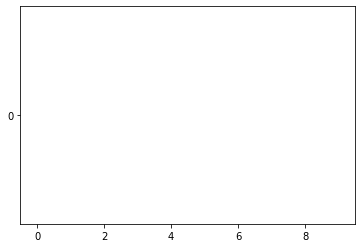

In [4]:
from norse.torch.utils.plot import plot_spikes_2d

plot_spikes_2d(output)

The y-axis shows the number of neurons (1 neuron with ID 0) and the x axis shows the timestep.
But. The plot is empty!
Perhaps that's because we didn't give it input. What if we activate our neuron with 1's instead of zeros?

<AxesSubplot:>

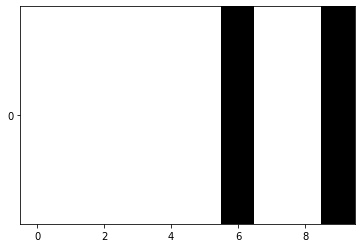

In [5]:
data = torch.ones(10, 1)
output, states = lif(data)
plot_spikes_2d(output)

Interesting! Now we see two spikes - one at time 6 (7th timestep) and time 9 (10th timestep).

However, beneath the scenes there are state variables at play we can introspect.

## Inspecting neuron state

The LIF neuron has a **voltage** (`"v"`) term that determines how close the neuron is to firing. 
We can now plot that term relatively easily.

<AxesSubplot:>

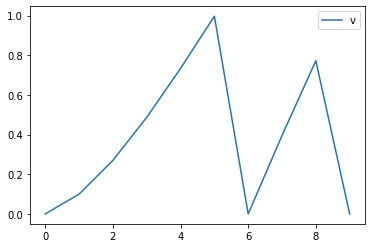

In [6]:
from norse.torch.utils.plot import plot_neuron_states

plot_neuron_states(states, "v")

This graph gives us a lot of information. 
First, note that it aligns with the graph above (notive the reset at 6 and 10).
This makes perfect sense because the voltage will reset immediately after firing.

Second, notice that the build-ups happen with different speeds. 
The growth between 0-1 and 6-7 is different! 
That is because of the "momentum" building up in the current term.
We won't go into that during this tutorial, but as you can tell these visualizations are vital to extract this kind of information.

As a small exercise, can you figure out how to visualize the current term (`"i"`)?

# 2. Simulating multiple neurons

To illustrate how a LIF neuron works, we wil simulate 10 neuros for 100 timesteps. Each of the 10 inputs (indexed from 0 to 9) will sent to the same neuron at every timestep, setting the size of our previously arbitrary sized population to 10. In the setup below, the input voltages follow the formula $i_n * 0.2$, where $i_n$ is the neuron index. Meaning, neuron 0 will receive an input of 0 for each timestep, so we do not expect that to spike. Neuron 1 will receive 0.2, so that *could* be enough for it to spike. Neuron 9 will receive an input of 1.80 every timestep, so we expect that to spike quite a few times.

In [7]:
# We are simulating 100 timesteps
timesteps = 100

# Create one current for each neuron (first neuron = 0, second neuron = 0.2, etc.)
neuron_currents = torch.tensor([0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8])

# Duplicate the neuron currents 100 times (timesteps)
population_currents = neuron_currents.repeat(100, 1)

# We now have 100 timesteps of unique currents for each of the 10 neurons
population_currents.shape

torch.Size([100, 10])

## Running the simulation

To run the simulation, we prepare a list of spikes and a state-variable, where the neuron states will be updated in. During the simulation, the states will update independently, resulting in different behaviours.

In [8]:
spikes, states = lif(population_currents)

We now have the spike data as a list of outputs for each timestep. Let's see how it looks at timestep 100:

In [9]:
spikes[99]

tensor([0., 0., 0., 0., 0., 1., 0., 1., 0., 0.], grad_fn=<SelectBackward0>)

The data tells us that at timestep 100, neuron 5 and 7 emitted a spike.

## Plotting the spikes

There are likely many more spikes, but it's too much work to go through the array one timestep at the time. A spike plot is much better suited to give us an overview.

<AxesSubplot:>

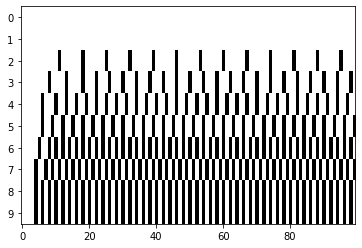

In [10]:
plot_spikes_2d(spikes)

We gave different inputs for different neurons.
For neurons 0 and 1, it's clear that the inputs weren't enough to cause any spikes!
For the other neurons, however, there are gradually more spikes as the input current increases.

We can inspect this spike pattern by summing up all the events in the time dimension and look at the individual activity for each neuron:

<AxesSubplot:>

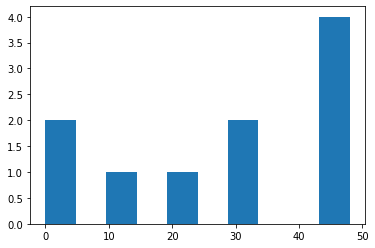

In [11]:
from norse.torch.utils.plot import plot_histogram_2d

plot_histogram_2d(spikes.sum(0))

Indeed, there seem to *something* in the dynamics of the LIF neuron that causes either 0 spikes, some spikes, up and until a spike "ceiling" of a bit less than 50 (in this case).
Let's validate that by inspecting the voltage membrane variables (`"v"`) for neurons 0, 1, and 8.

<AxesSubplot:>

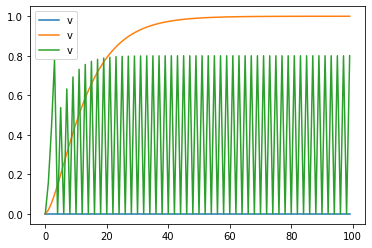

In [12]:
spikes, states = lif(population_currents[:,[0,1,8]])
plot_neuron_states(states, "v")

This matches our expectation: the neuron 0 gets zero input and is lying flat at the bottom.
Neuron 1 gets current, but not enough to spike!
Neuron 8, however is rapidly firing throughout.

## Conclusion

Hopefully, this tutorial helped you gain some tools to plot spikes and neuron state variables and gave you some pointers on how to gain insights into spiking data in Norse.
There are more [primivites to explore for plotting](https://norse.github.io/norse/norse.torch.utils.html) that we did not get to, but they are relatively simple; the most important thing is to understand the shape and nature of your data, such that you can manipulate it in any way you need.

## Additional resources

Please have a look [at our other notebooks](https://github.com/norse/notebooks) and [our documentation](https://norse.github.io/norse/) - particularly for the [plotting utilities](https://norse.github.io/norse/norse.torch.utils.html).

For an excellent introduction to neuron dynamics and much more, see the [Neuromatch Academy Python tutorial](https://compneuro.neuromatch.io/tutorials/W0D1_PythonWorkshop1/student/W0D1_Tutorial1.html).